4/4 [==============================] - 1s 161ms/step
Epoch 0, [D loss: 0.7063637971878052, acc.: 4.296875%], [G loss: 0.7049487829208374]
1/1 [==============================] - 0s 232ms/step


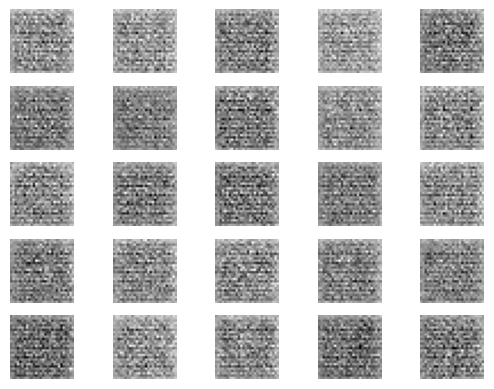

4/4 [==============================] - 1s 151ms/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7, 7), activation='tanh', padding='same')) # Change 3 to the number of channels in your images
    return model

def build_discriminator(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return gan


# Define constants
latent_dim = 100
input_shape = x_train.shape[1:]
epochs = 20000
batch_size = 128
sample_interval = 1000

# Build and compile the discriminator
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_dim)

# Build and compile the GAN model
gan = build_gan(generator, discriminator)

# Train the GAN
for epoch in range(epochs):
    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_images = x_train[idx]

    # Generate a batch of fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_images = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator (via the GAN model)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print progress and save generated images at sample intervals
    if epoch % sample_interval == 0:
        print(f"Epoch {epoch}, [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%], [G loss: {g_loss}]")
        # Save generated images
        save_generated_images(epoch, generator, latent_dim)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

# Define the dimensions of the random noise vector
noise_dim = 100

# Define the generator model
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(784, activation='tanh')) # Output layer with tanh activation
    model.add(Reshape((28, 28, 1))) # Reshape output to image dimensions
    return model

# Define the discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid')) # Output layer with sigmoid activation
    return model

# Compile the discriminator model
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(lr=0.0002, beta_1=0.5),
                      metrics=['accuracy'])

# Make the discriminator untrainable when we are training the generator
discriminator.trainable = False

# Define the GAN model
generator = build_generator()
gan_input = Input(shape=(noise_dim,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Load the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()

# Normalize data
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=-1)

# Training the GAN
epochs = 3  # Adjust number of epochs as needed
batch_size = 64
batch_count = X_train.shape[0] // batch_size

for epoch in range(epochs):
    for batch in range(batch_count):
        # Generate random noise as input for the generator
        noise = np.random.normal(0, 1, size=[batch_size, noise_dim])

        # Generate fake images
        generated_images = generator.predict(noise)

        # Get a random set of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        # Concatenate real and fake images into a single array
        X = np.concatenate([real_images, generated_images])

        # Labels for real and fake images
        y_dis = np.zeros(2 * batch_size)
        y_dis[:batch_size] = 0.9  # Label smoothing

        # Train discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batch_size, noise_dim])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)

    # Print progress and display generated images
    print(f'Epoch: {epoch+1} | Discriminator Loss: {d_loss[0]} | Generator Loss: {g_loss}')
    if (epoch + 1) % 5 == 0:
        # Generate some synthetic images
        n_samples = 10
        noise = np.random.normal(0, 1, size=[n_samples, noise_dim])
        generated_images = generator.predict(noise)

        # Display the generated images
        plt.figure(figsize=(10, 10))
        for i in range(n_samples):
            plt.subplot(1, n_samples, i+1)
            plt.imshow(generated_images[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.show()


2/2 [==============================] - 0s 8ms/step
Epoch: 1 | Discriminator Loss: 0.5522506237030029 | Generator Loss: 1.3256853818893433
2/2 [==============================] - 0s 7ms/step
Epoch: 2 | Discriminator Loss: 0.5250142812728882 | Generator Loss: 1.4500269889831543
2/2 [==============================] - 0s 16ms/step
Epoch: 3 | Discriminator Loss: 0.5435971021652222 | Generator Loss: 1.4073166847229004
